## End to End Machine Learning-Based Prediction of Medical Insurance Premiums with AWS Sagemaker

#### TASK 1: UNDERSTAND THE PROBLEM STATEMENT 

##### Aims and objectives
Make predictions about health insurance companies based on personal traits like age, gender, BMI, number of children, smoking habit and geographical location.

* Features are:

    * sex: insurance contractor gender, female, male

    * bmi: Body mass index (ideally 18.5 to 24.9)

    * children: Number of children covered by health insurance / Number of dependents

    * smoker: smoking habits

    * region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

    * charges: Individual medical costs billed by health insurance.

#### TASK 2: IMPORT LIBRARIES AND DATASETS

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

import boto3
import sagemaker
from sagemaker import Session
import io
import sagemaker.amazon.common as smac
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

In [8]:
# read the csv file 
df = pd.read_csv('insurance_data.csv')

In [9]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### TASK 3: PERFORM EXPLORATORY DATA ANALYSIS:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [20]:
# Check unique values in the 'sex' column
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [21]:
# convert categorical variable to numerical
df['sex'] = df['sex'].apply(lambda x: 0 if x == 'female' else 1)

In [22]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [23]:
# Check the unique values in the 'smoker' column
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [24]:
# Convert categorical variable to numerical 

df['smoker'] = df['smoker'].apply(lambda x: 0 if x == 'no' else 1)

In [25]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [26]:
# Check unique values in 'region' column
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [30]:
region_dummies = pd.get_dummies(df['region'], drop_first = True, dtype=int)
region_dummies

,northwest,southeast,southwest
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
1333,1,0,0
1334,0,0,0
1335,0,1,0
1336,0,0,1


In [31]:
df = pd.concat([df, region_dummies], axis = 1)

In [32]:
df.head()

,age,sex,bmi,children,smoker,region,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,southwest,16884.92400,0,0,1
1,18,1,33.770,1,0,southeast,1725.55230,0,1,0
2,28,1,33.000,3,0,southeast,4449.46200,0,1,0
3,33,1,22.705,0,0,northwest,21984.47061,1,0,0
4,32,1,28.880,0,0,northwest,3866.85520,1,0,0


In [33]:
# Let's drop the original 'region' column 
df.drop(['region'], axis = 1, inplace = True)

In [34]:
df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


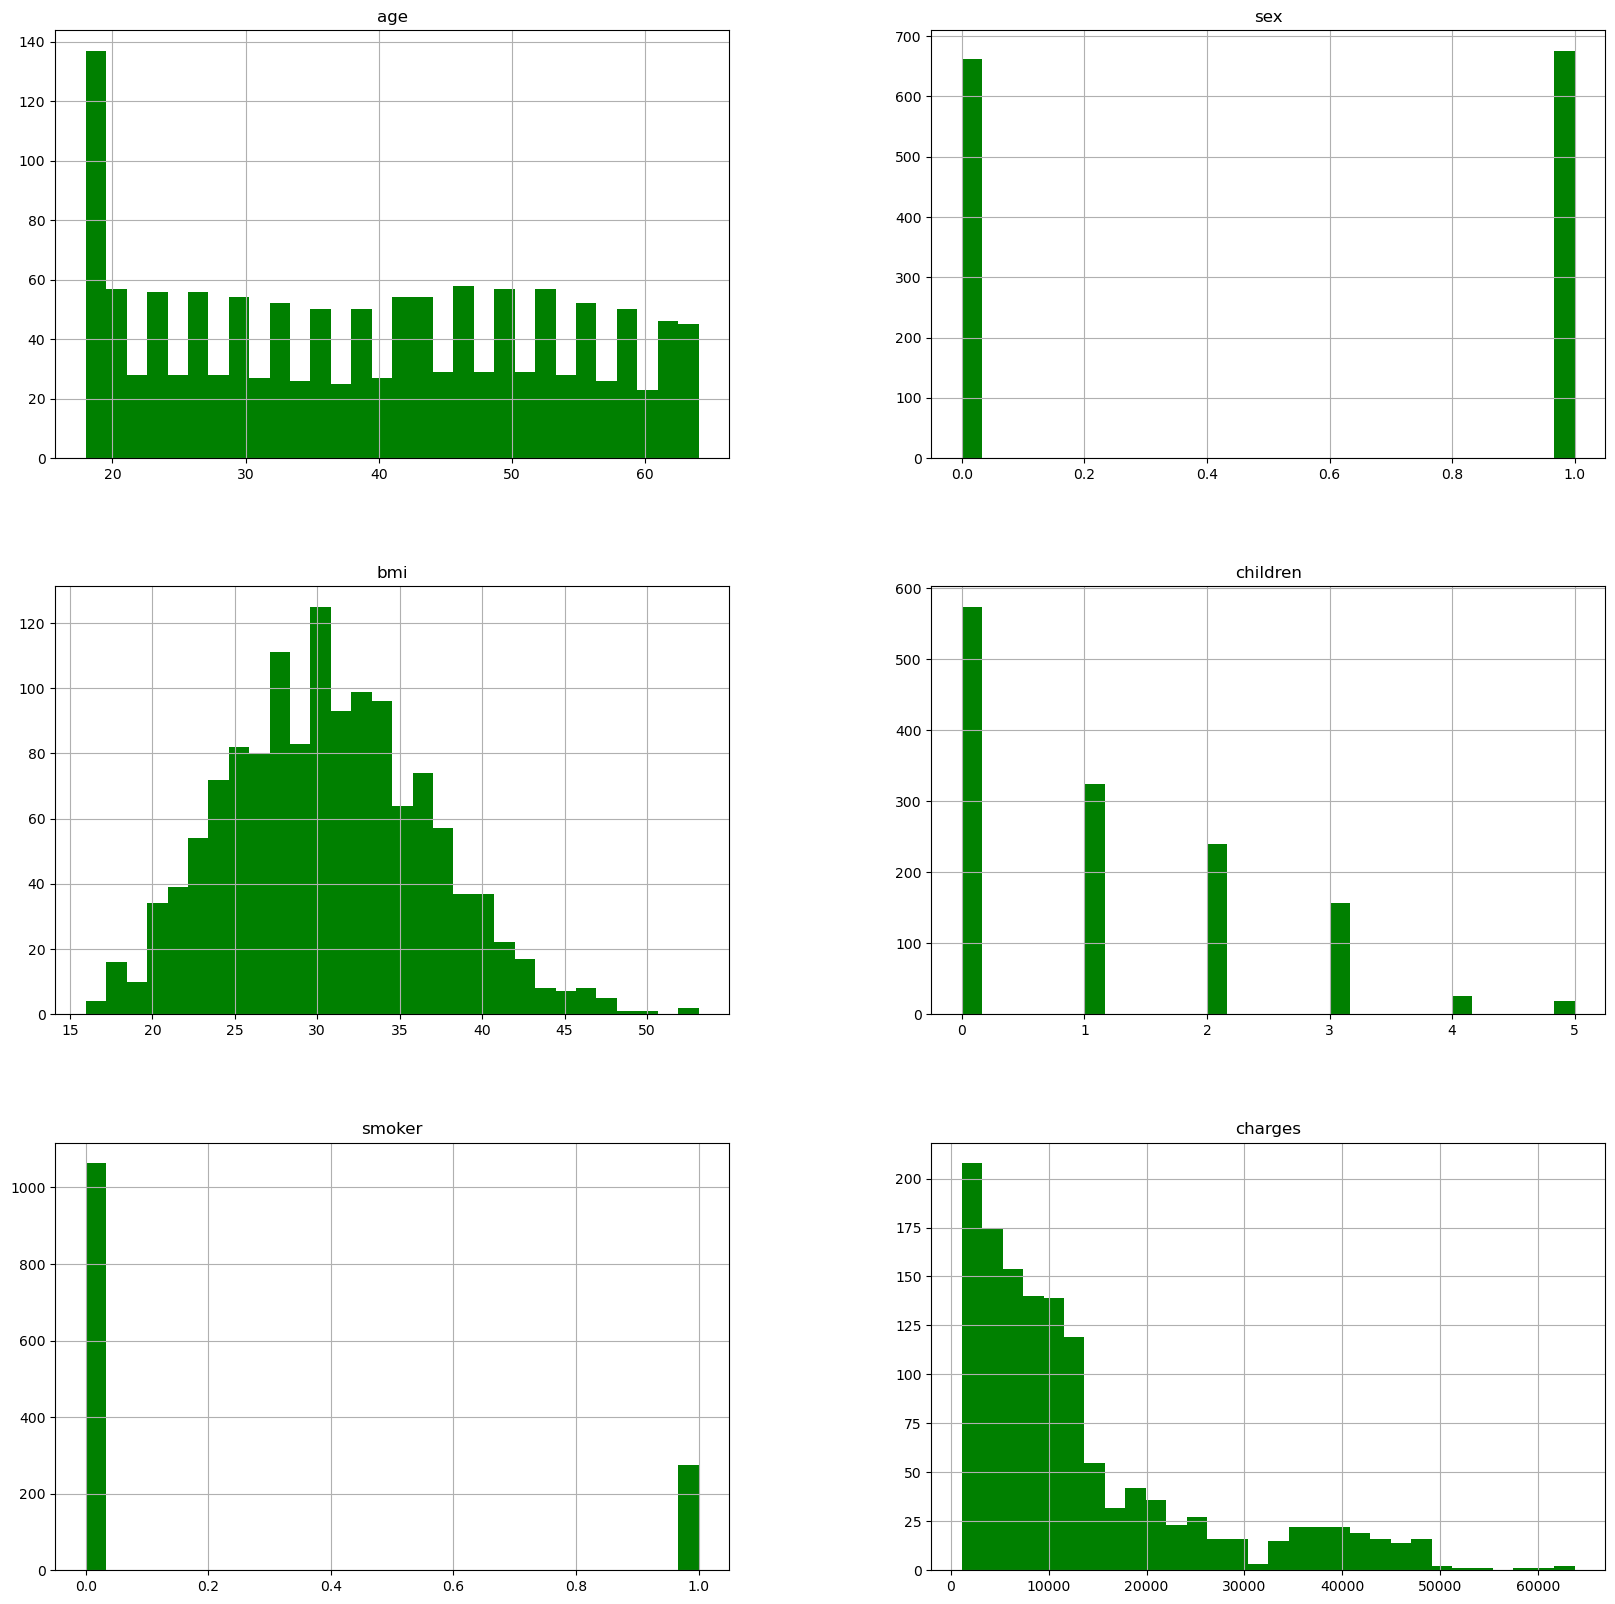

In [37]:
df[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']].hist(bins = 30, figsize = (20,20), color = 'g')
plt.show()

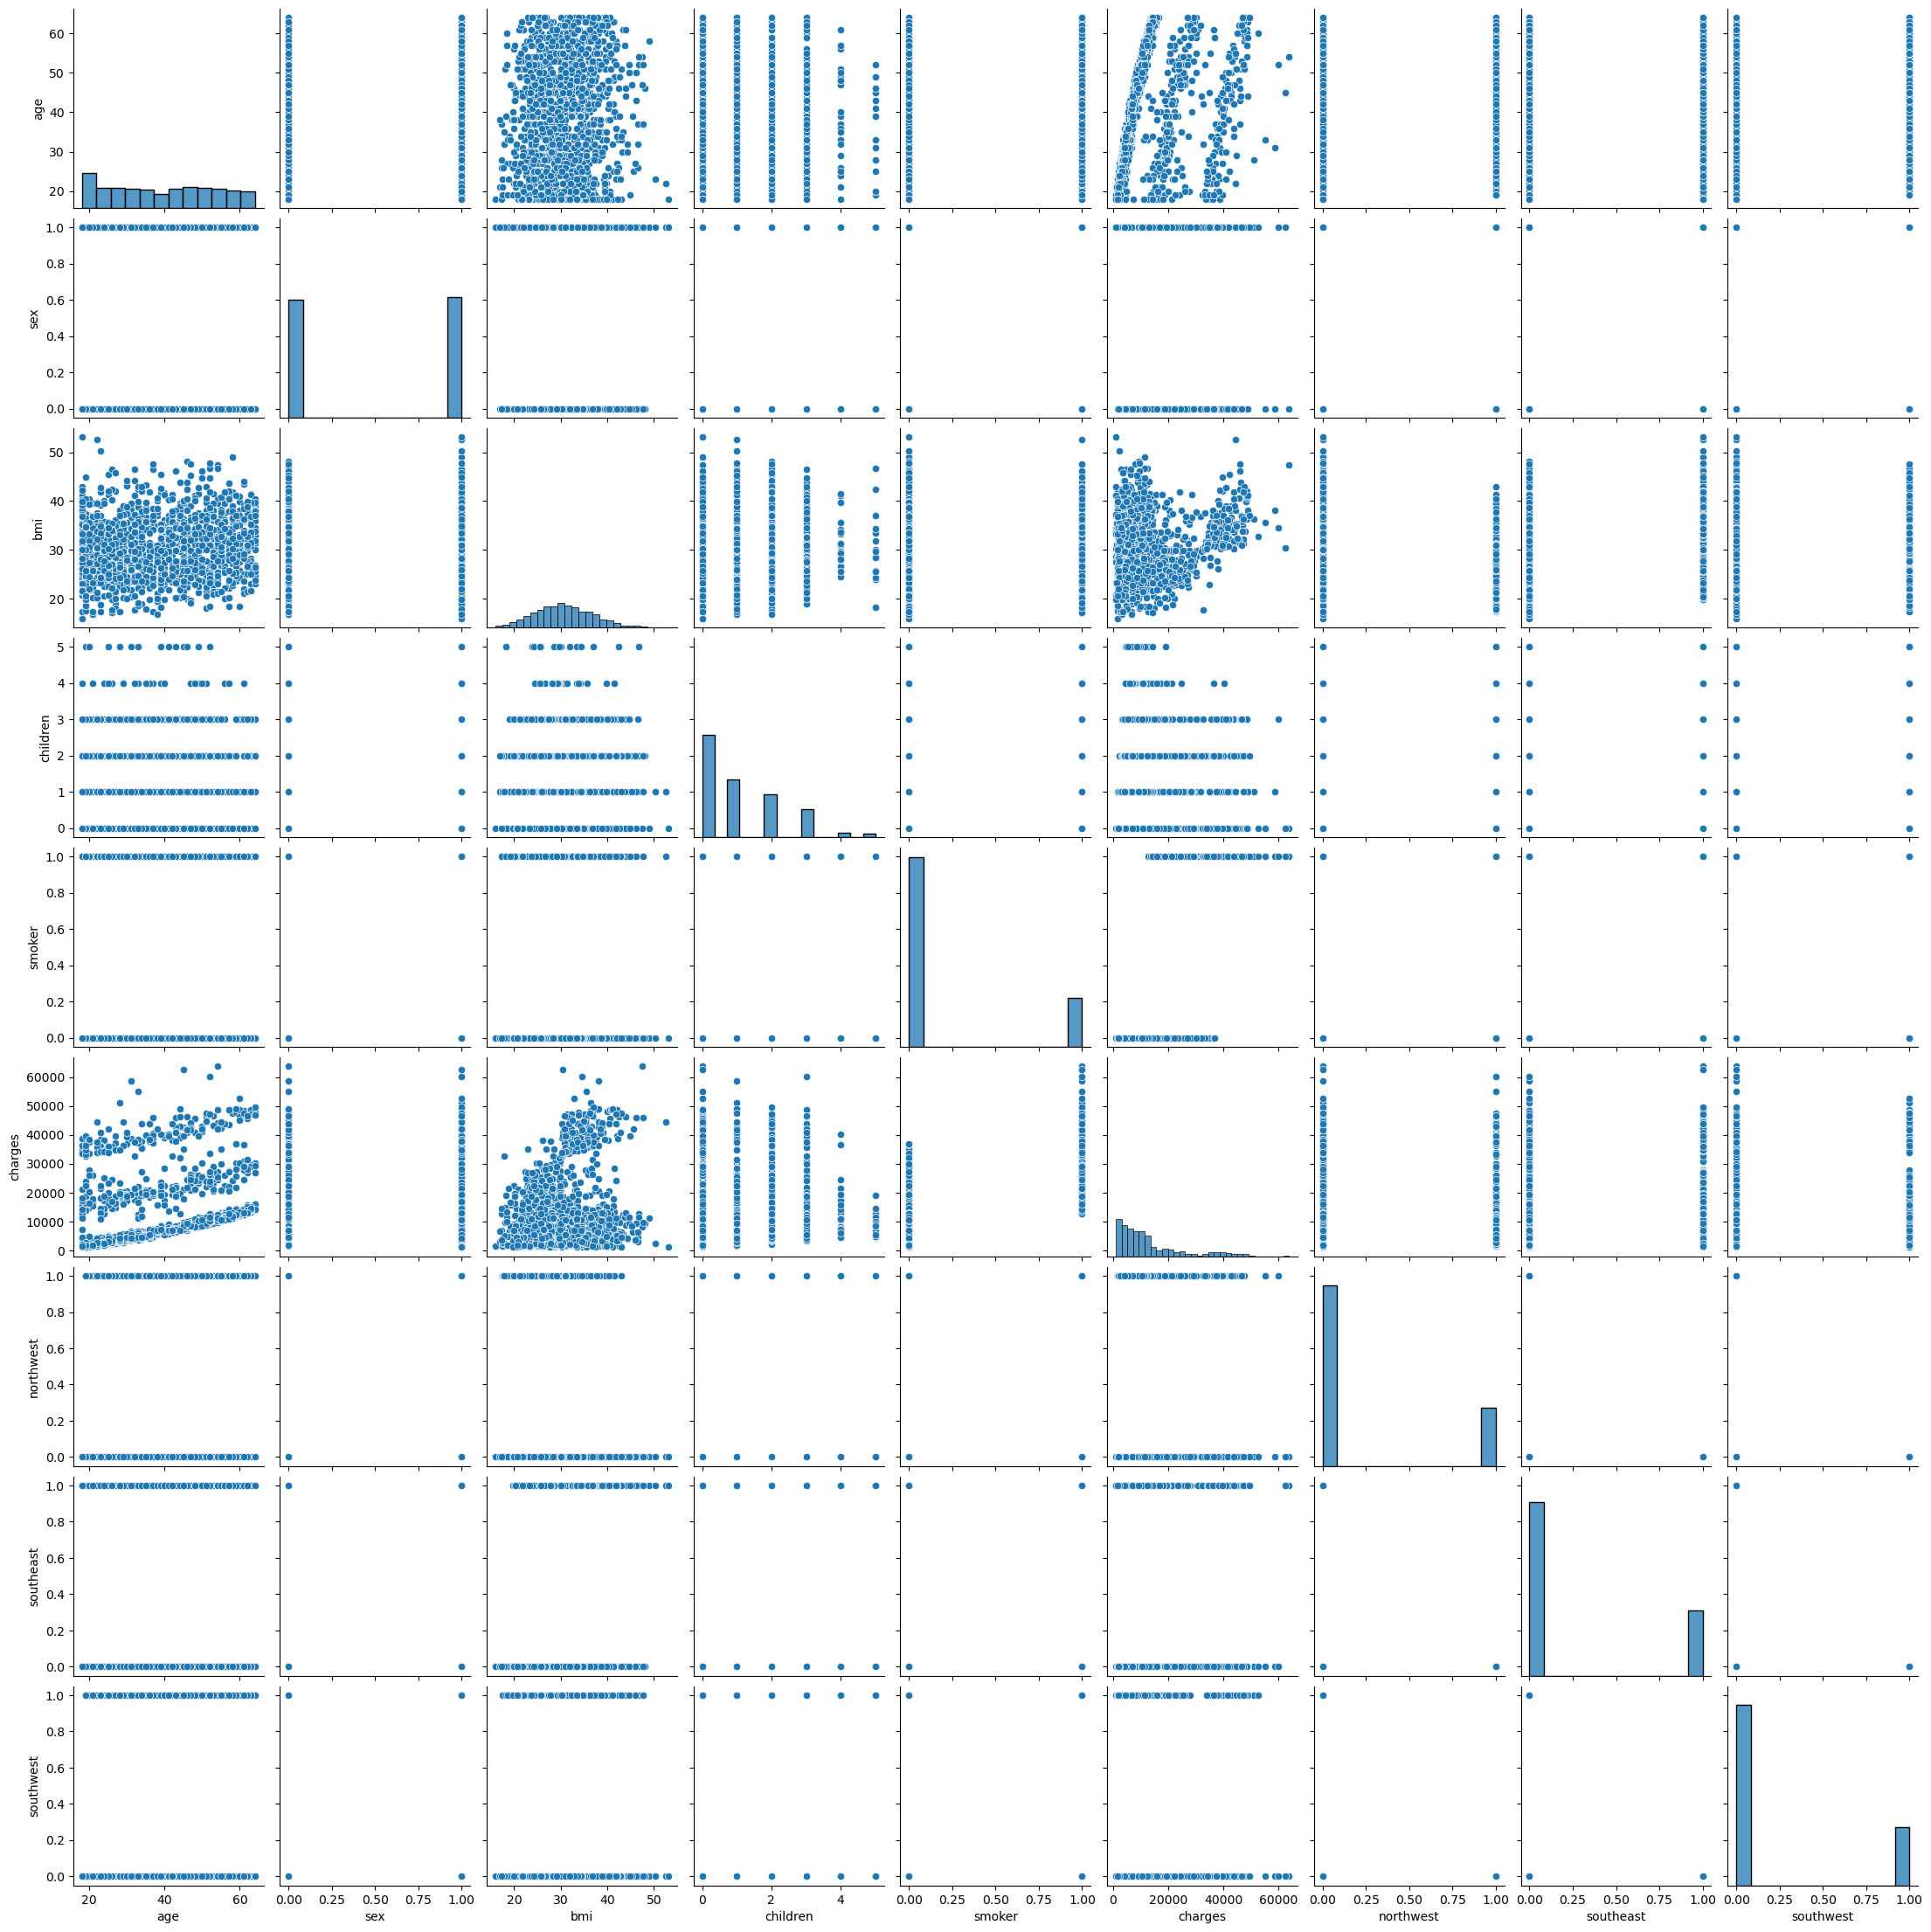

In [43]:
# plot pairplot

sns.pairplot(df)

#### TASK 4: CREATE TRAINING AND TESTING DATASET

In [44]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'northwest',
       'southeast', 'southwest'],
      dtype='object')

In [45]:
X = df.drop(columns =['charges'])
y = df['charges']

In [46]:
X.head()

,age,sex,bmi,children,smoker,northwest,southeast,southwest
0,19,0,27.900,0,1,0,0,1
1,18,1,33.770,1,0,0,1,0
2,28,1,33.000,3,0,0,1,0
3,33,1,22.705,0,0,1,0,0
4,32,1,28.880,0,0,1,0,0


In [47]:
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [48]:
X.shape, y.shape

((1338, 8), (1338,))

In [49]:
#Convert X and y float64 to float32
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [50]:
y

array([16884.924 ,  1725.5522,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.36  ], dtype=float32)

In [51]:
y = y.reshape(-1,1)
y

array([[16884.924 ],
       [ 1725.5522],
       [ 4449.462 ],
       ...,
       [ 1629.8335],
       [ 2007.945 ],
       [29141.36  ]], dtype=float32)

In [52]:
# Only take the numerical variables and scale them
X 

array([[19.  ,  0.  , 27.9 , ...,  0.  ,  0.  ,  1.  ],
       [18.  ,  1.  , 33.77, ...,  0.  ,  1.  ,  0.  ],
       [28.  ,  1.  , 33.  , ...,  0.  ,  1.  ,  0.  ],
       ...,
       [18.  ,  0.  , 36.85, ...,  0.  ,  1.  ,  0.  ],
       [21.  ,  0.  , 25.8 , ...,  0.  ,  0.  ,  1.  ],
       [61.  ,  0.  , 29.07, ...,  1.  ,  0.  ,  0.  ]], dtype=float32)

In [54]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [56]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

#### TASK 5: TRAIN AND TEST A LINEAR REGRESSION MODEL

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [59]:
acc = lr.score(X_test, y_test)
acc

0.7835929722044683

In [60]:
y_pred = lr.predict(X_test)

In [61]:
y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [62]:
k = X_test.shape[1]
n = len(X_test)
n

268

In [64]:
RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)

In [66]:
#print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

#### TASK 6: TRAIN A LINEAR LEARNER MODEL USING SAGEMAKER

In [70]:
#create a Sagemaker session
sagemaker_session = sagemaker.Session()
bucket = Session().default_bucket()
prefix = 'linear-learner'
role = sagemaker.get_execution_role()
print(bucket)
print(prefix)
print(role)

sagemaker-us-east-1-381491844848
linear-learner
arn:aws:iam::381491844848:role/service-role/AmazonSageMaker-ExecutionRole-20240905T111695


In [71]:
X_train.shape

(1070, 8)

In [72]:
y_train.shape

(1070, 1)

In [77]:
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X_train, y_train.reshape(-1))
buffer.seek(0)

0

In [79]:
# Upload RecordIO data to S3
 
# Key refers to the name of the file    
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buffer)

# Print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-381491844848/linear-learner/train/linear-train-data


In [80]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-381491844848/linear-learner/output


In [82]:
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [83]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)


# We can tune parameters like the number of features that we are passing in, type of predictor like 'regressor' or 'classifier', mini batch size, epochs
# Train 32 different versions of the model and will get the best out of them (built-in parameters optimization!)

linear.set_hyperparameters(feature_dim = 8,
                           predictor_type = 'regressor',
                           mini_batch_size = 100,
                           epochs = 100,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-09-05-11-56-06-420


2024-09-05 11:56:07 Starting - Starting the training job...
2024-09-05 11:56:23 Starting - Preparing the instances for training...
2024-09-05 11:56:55 Downloading - Downloading input data...
2024-09-05 11:57:41 Downloading - Downloading the training image.........
2024-09-05 11:58:57 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/05/2024 11:59:06 INFO 140629400323904] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

#### TASK #8: DEPLOY AND TEST THE TRAINED LINEAR LEARNER MODEL 

In [84]:
# Deploying the model to perform inference 

linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2024-09-05-12-19-28-879
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-09-05-12-19-28-879
INFO:sagemaker:Creating endpoint with name linear-learner-2024-09-05-12-19-28-879


--------!

In [88]:
linear_regressor.serializer = CSVSerializer()
linear_regressor.deserializer = JSONDeserializer()

In [89]:
result = linear_regressor.predict(X_test)

In [90]:
result

{'predictions': [{'score': -0.3947466015815735},
  {'score': -0.6545196771621704},
  {'score': 2.3229310512542725},
  {'score': -0.42945200204849243},
  {'score': 1.3633484840393066},
  {'score': -0.5180152058601379},
  {'score': -1.112980604171753},
  {'score': 0.03642118722200394},
  {'score': -0.9007824659347534},
  {'score': -0.3309958577156067},
  {'score': 1.6265026330947876},
  {'score': -0.5096449851989746},
  {'score': -0.7669842839241028},
  {'score': 2.1663198471069336},
  {'score': 2.3962628841400146},
  {'score': 2.1298465728759766},
  {'score': -0.15974587202072144},
  {'score': 2.098792552947998},
  {'score': -0.4064822793006897},
  {'score': 1.8570022583007812},
  {'score': -0.8365532159805298},
  {'score': -0.40815243124961853},
  {'score': -1.0079283714294434},
  {'score': -0.7900637984275818},
  {'score': -0.29928848147392273},
  {'score': -0.1572418510913849},
  {'score': -0.0316624790430069},
  {'score': -0.7848987579345703},
  {'score': -0.33493945002555847},
  {'

In [93]:
result_preds = np.array([res['score'] for res in result['predictions']])

In [94]:
result_preds

array([-3.94746602e-01, -6.54519677e-01,  2.32293105e+00, -4.29452002e-01,
        1.36334848e+00, -5.18015206e-01, -1.11298060e+00,  3.64211872e-02,
       -9.00782466e-01, -3.30995858e-01,  1.62650263e+00, -5.09644985e-01,
       -7.66984284e-01,  2.16631985e+00,  2.39626288e+00,  2.12984657e+00,
       -1.59745872e-01,  2.09879255e+00, -4.06482279e-01,  1.85700226e+00,
       -8.36553216e-01, -4.08152431e-01, -1.00792837e+00, -7.90063798e-01,
       -2.99288481e-01, -1.57241851e-01, -3.16624790e-02, -7.84898758e-01,
       -3.34939450e-01, -1.04250884e+00, -4.51300263e-01, -1.69042349e-01,
       -9.09027517e-01, -8.31512690e-01, -8.35221052e-01, -2.95454204e-01,
       -9.69451666e-01, -4.43430126e-01,  2.04857850e+00,  1.82355392e+00,
       -9.03080463e-01, -9.44698453e-01, -9.10999775e-02, -2.09295660e-01,
       -6.05485916e-01, -1.30122572e-01, -9.04769599e-01, -8.59987080e-01,
        2.03066230e+00, -6.21268392e-01,  3.83173376e-02, -1.02911830e+00,
       -4.20577645e-01, -

In [110]:
RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 5796.284 
MSE = 33596910.0 
MAE = 4181.1943 
R2 = 0.7835929909347372 
Adjusted R2 = 0.776908604554343


In [111]:
# Delete the end-point

linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2024-09-05-12-19-28-879
INFO:sagemaker:Deleting endpoint with name: linear-learner-2024-09-05-12-19-28-879
